# ERA5-Land Stündliche Daten

ERA5-Land ist ein hochauflösendes Reanalyse-Datensatz, der eine konsistente und detaillierte Ansicht von Landvariablen über mehrere Jahrzehnte hinweg bietet. Durch die Kombination von Modelldaten mit atmosphärischer Antriebskraft aus ERA5 wird eine hohe Genauigkeit sichergestellt. Durch die Korrektur von Eingangsvariablen für Höhenunterschiede und die Nutzung indirekter Beobachtungseinflüsse bietet ERA5-Land eine verbesserte Präzision für Anwendungen im Bereich der Landoberflächenanalyse, wie z. B. Hochwasser- und Dürrevorhersagen. Trotz gewisser Unsicherheiten macht die umfangreiche zeitliche und räumliche Auflösung ERA5-Land zu einer wertvollen Ressource für Entscheidungsfindung und Umweltanalysen.

**Informationen zum Datensatz:**
* Quelle: [ERA5-Land Hourly Data](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview')
* Author: str.ucture GmbH
* Notebook-Version: 1.2 (Aktualisiert: März 05, 2025)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\era5-land-hourly-data\download"
working_folder = r".\data\era5-land-hourly-data\working"
geotiff_folder = r".\data\era5-land-hourly-data\geotiff"
csv_folder = r".\data\era5-land-hourly-data\csv"
output_folder = r".\data\era5-land-hourly-data\output"
''' ----- Ende der Angaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Herunterladen und Entpacken des Datensatzes

### 2.1 Authentifizierung

In [2]:
import cdsapi

def main():
    # API-Key für die Authentifizierung
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Erstellung des CDS-API-Clients
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Definieren Sie die „request“ und laden Sie den Datensatz herunter

In [3]:
import ipywidgets as widgets
import _utils.extra_era5_land_hourly as utils

var_group_name_list = utils.var_group_name_list
var_group_dict = utils.var_group_dict

selected_variable_group = widgets.Dropdown(
    options = var_group_name_list,
    value = var_group_name_list[0],
    description = "Wähle eine Variablengruppe",
    style = dict(description_width='initial'),
    layout = widgets.Layout(width='50%'),
)

selected_variable_group

Dropdown(description='Wähle eine Variablengruppe', layout=Layout(width='50%'), options=('var_group_temperature…

In [4]:
current_variable_group = var_group_dict[selected_variable_group.value]

selected_variable = widgets.Dropdown(
    options=current_variable_group,
    value=current_variable_group[1],
    description="Wähle die gewünschte Variable",
    style=dict(description_width='initial'),
    layout=widgets.Layout(width='50%'),
)

selected_variable

Dropdown(description='Wähle die gewünschte Variable', index=1, layout=Layout(width='50%'), options=('2m_dewpoi…

### 2.3 Definiere das "Jahr" zum Herunterladen

> Hinweis: Für das ausgewählte **Jahr** sind alle Monate (Januar bis Dezember), Tage (1 bis 30/31) und Stunden (00:00 bis 23:00) im "request"-Parameter angegeben. Ändere diese Einstellung, um die Dateigröße zu reduzieren oder einen spezifischen Datensatz herunterzuladen.

In [5]:
from datetime import datetime

selected_year = widgets.Dropdown(
    options=[str(year) for year in range(1950, 2024+1)],
    value=str(2024),
    description="Wähle das Jahr zum Herunterladen der Daten:",
    disabled=False,
    style=dict(description_width='initial'),
    layout=widgets.Layout(width='50%'),
)

selected_year

Dropdown(description='Wähle das Jahr zum Herunterladen der Daten:', index=74, layout=Layout(width='50%'), opti…

### 2.3 Define Bounding Box Extents (Bbox)

In [6]:
# Definieren der Begrenzungsrahmen-Koordinaten (WGS84-Format)
# Das Koordinatenformat lautet: [Norden, Westen, Süden, Osten]
bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_de_standard = [5.7, 47.1, 15.2, 55.2]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # [West, South, East, North]

# Alternativ können Sie ein Shapefile für eine präzise geografische Filterung verwenden
import geopandas as gpd
import math

# Beispiel: Shapefile von Konstanz laden (WGS84-Projektion)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)

# Extrahieren Sie den Begrenzungsrahmen des Shapefiles
de_bounds = de_gdf.total_bounds

# Passen Sie den Begrenzungsrahmen an und puffern Sie ihn, um einen etwas größeren
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

# Ordnen Sie die Koordinaten in das Format: [Nord, West, Süd, Ost] um.
bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

### 2.4 Definiere "Datensatz" und "Anfrage"

In [7]:
# Definition des Datensatzes und der Request-Parameter
dataset = "reanalysis-era5-land"
request = {
    "variable": selected_variable.value,
    "year": selected_year.value,
    "month": [str(month) for month in range(13)],
    "day": [str(day) for day in range(32)],
    "time": [f"{hour:02d}:00" for hour in range(24)],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": bbox_de_bounds_adjusted
}

In [8]:
download_folder_subset = os.path.join(download_folder, f"{selected_variable.value}")
os.makedirs(download_folder_subset, exist_ok=True)

# Führen Sie es aus, um den Datensatz herunterzuladen:
def main_retrieve():
    dataset_filename = f"{dataset}-{selected_variable.value}-{selected_year.value}.nc"
    dataset_filepath = os.path.join(download_folder_subset, dataset_filename)

    # Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
    if not os.path.isfile(dataset_filepath):
        # Rufen Sie den CDS-Client nur auf, wenn der Datensatz noch nicht heruntergeladen wurde.
        client = main()
        # Den Datensatz mit den definierten Anforderungsparametern herunterladen
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Datensatz bereits heruntergeladen.")

if __name__ == "__main__":
    main_retrieve()

Datensatz bereits heruntergeladen.


### 2.3 Entpacke die ZIP-Datei im Ordner

> Hinweis: Da der Datensatz für eine einzelne Variable heruntergeladen wird, wird nur eine NetCDF-Datei heruntergeladen, und das CDS erstellt keine ZIP-Datei für eine einzelne Variable im NetCDF-Format.

In [9]:
# import zipfile

# Definieren Sie einen Extraktionsordner für die ZIP-Datei, der dem Arbeitsordner entspricht
# extract_folder = working_folder

# # Extract the ZIP file
# try:   
#     if not os.listdir(extract_folder):
#         dataset_filename = f"{dataset}.zip"
#         dataset_filepath = os.path.join(download_folder, dataset_filename)

#         with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
#             zip_ref.extractall(extract_folder)
#             print(f"Dateien erfolgreich extrahiert nach: {extract_folder}")
#     else:
#         print("Ordner ist nicht leer. Entpacken überspringen.")
# except FileNotFoundError:
#     print(f"Fehler: Die Datei {dataset_filepath} wurde nicht gefunden.")
# except zipfile.BadZipFile:
#     print(f"Fehler: Die Datei {dataset_filepath} ist keine gültige ZIP-Datei.")
# except Exception as e:
#     print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

## 3. Untersuchen der Metadaten der NetCDF4-Datei

### 3.1 Erstellen eines DataFrame mit verfügbaren NetCDF-Dateien

In [10]:
import re
import pandas as pd
import netCDF4 as nc

def meta(filename):
    # Überprüfen, ob der Dateiname dem erwarteten Muster entspricht
    match = re.search(r"(?P<dataset>reanalysis-era5-land)-(?P<ds_variable>\d+m_[a-z_]+)-(?P<year>\d{4})",filename)

    # Fehler ausgeben, wenn der Dateiname nicht dem erwarteten Schema entspricht
    if not match:
        match = re.search("Der angegebene Dateiname entspricht nicht dem erwarteten Benennungsschema.")
    
    # Funktion zum Extrahieren des Variablennamens aus der NetCDF-Datei
    def get_nc_variable():
        with nc.Dataset(os.path.join(download_folder_subset, filename), 'r') as nc_dataset:
            nc_variable_name = nc_dataset.variables.keys()
            return [*nc_variable_name][5]

    # Metadaten als Dictionary zurückgeben
    return dict(
        filename=filename,
        path=os.path.join(download_folder_subset, filename),
        # index=match.group('index'),
        dataset=match.group('dataset'),
        ds_variable=match.group('ds_variable'),
        variable_name=get_nc_variable(),
        year=match.group('year')
    )

# Metadaten für alle NetCDF-Dateien im Ordner extrahieren
# Das Dictionary 'nc_files' enthält alle relevanten Metadaten der verfügbaren NetCDF4-Dateien
# Dieses Dictionary wird später verwendet, um die Dateien in GeoTiff zu konvertieren
nc_files = [meta(f) for f in os.listdir(download_folder_subset) if f.endswith('.nc')]
nc_files = sorted(nc_files, key=lambda x: x['year'])  # Nach Jahr sortieren
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Pandas-Anzeigeoptionen anpassen
pd.options.display.max_colwidth = 24

# DataFrame anzeigen, ohne die Spalte 'path' darzustellen
df_nc_files.head(10).loc[:, df_nc_files.columns != 'path']

,filename,dataset,ds_variable,variable_name,year
0,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1950
1,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1951
2,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1952
3,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1953
4,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1954
5,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1955
6,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1956
7,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1957
8,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1958
9,reanalysis-era5-land...,reanalysis-era5-land,2m_temperature,t2m,1959


### 3.2 Einzigartige Variablennamen und verfügbare Variablen ausgeben

In [11]:
# Variable definieren, um bereits verarbeitete Variablennamen zu speichern und Duplikate zu vermeiden  
seen_variables = set()

# Alle Variablen in jeder NetCDF-Datei auflisten
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde
    if variable_name in seen_variables:
        continue

    # NetCDF-Datei im Lesemodus öffnen
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
        # Alle Variablen im aktuellen Datensatz auflisten
        variables_list = list(nc_dataset.variables.keys())
        
        # Details der Datei und ihrer Variablen ausgeben
        print(f"{i + 1:<2} {variable_name:<18}: Verfügbare Variablen: {variables_list}") 
    
    # Diese Variable als verarbeitet markieren
    seen_variables.add(variable_name)

1  t2m               : Verfügbare Variablen: ['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m']


In [12]:
# Alle Variableninformationen in jeder NetCDF-Datei auflisten
seen_variables = set()

# Alle variablen Informationen in jeder NetCDF-Datei auflisten
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde
    if variable_name in seen_variables:
        continue
    
    # NetCDF-Datei im Lesemodus öffnen
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
        # Primärvariable-Daten abrufen
        variable_data = nc_dataset[variable_name]

        # Zusammenfassung der Primärvariable erstellen
        summary = {
            "Variablenname": variable_name,
            "Datentyp": variable_data.dtype,
            "Form": variable_data.shape,
            "Variableninfo": f"{variable_data.dimensions}",
            "Einheiten": getattr(variable_data, "units", "N/A"),
            "Langer Name": getattr(variable_data, "long_name", "N/A"),
        }  

        # Datensatz-Zusammenfassung als DataFrame zur besseren Visualisierung anzeigen
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Beschreibung', 'Bemerkungen'])
        print(f"{i + 1}. Zusammenfassung der Variable '{variable_name}':")
        display(nc_summary)

    # Variablenname zur Liste der bereits verarbeiteten Variablen hinzufügen
    seen_variables.add(variable_name)

    # Ausgabe begrenzen
    output_limit = 2
    if len(seen_variables) >= output_limit:
        print(f".... (Ausgabe auf die ersten {output_limit} Variablen gekürzt)")
        break

1. Zusammenfassung der Variable 't2m':


,Beschreibung,Bemerkungen
0,Variablenname,t2m
1,Datentyp,float32
2,Form,"(8759, 82, 96)"
3,Variableninfo,"('valid_time', 'lati..."
4,Einheiten,K
5,Langer Name,2 metre temperature


## 4. Exportieren der NetCDF4-Dateien im CSV-Format

### 4.1 Definieren eine Funktion zum Konvertieren von NetCDF-Daten in DataFrame

In [13]:
import xarray as xr

# Funktion zur Konvertierung von NetCDF-Daten in ein Pandas DataFrame
def netcdf_to_dataframe(
    nc_file,
    bounding_box=None):

    # Öffne das NetCDF-Dataset im Lesemodus
    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Zugriff auf die Variablendaten aus dem Datensatz
        variable_data = nc_dataset[nc_file['variable_name']]
        
        # Sicherstellen, dass die Namen für Breiten- und Längengrad korrekt sind
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Falls eine Begrenzungsbox angegeben ist, die Daten filtern
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Umwandlung des xarray-Datensatzes in ein Pandas DataFrame
        df = filtered_data.to_dataframe().reset_index()

        # Entfernen nicht benötigter Spalten (variiert je nach Datensatz)
        if 'height' in df.columns:
            df = df.drop(columns=['number'])
        if 'quantile' in df.columns:
            df = df.drop(columns=['expver'])
            
        # Valid_time in Datum und Uhrzeit aufteilen
        df['valid_time'] = pd.to_datetime(df['valid_time'])
        df['date'] = df['valid_time'].dt.date
        df['time'] = df['valid_time'].dt.time
        df = df.set_index(['date', 'time', latitude_name, longitude_name])
 
        return df

### 4.2 Nach Begrenzungsrahmen filtern, DataFrame erstellen und als CSV-Datei exportieren

In [14]:
# Erstelle einen Ordner zum Speichern der Teilmengen-CSV-Dateien basierend auf der ausgewählten Variable
subset_csv_folder = os.path.join(csv_folder, f"{selected_variable.value}")
os.makedirs(subset_csv_folder, exist_ok=True)

# Exportiere alle netCDF4-Dateien als einzelne CSV-Dateien
for nc_file in nc_files:
    # CSV-Dateiname und Pfad für die Ausgabe definieren
    csv_filename = f"{nc_file['variable_name']}-{nc_file['year']}.csv"
    csv_filepath = os.path.join(subset_csv_folder, csv_filename)

    # Exportiere das DataFrame als CSV, falls es noch nicht existiert
    if not os.path.isfile(csv_filepath):
        dataframe = netcdf_to_dataframe(nc_file, bounding_box=bbox_wgs84_konstanz_standard)
        dataframe.to_csv(csv_filepath, sep=',', encoding='utf8')
    else:
        print(f"Datei existiert bereits unter {csv_filepath}.\nÜberspringen den Export.")
        break

print("Letzte vorhandene CSV-Datei lesen...")
dataframe = pd.read_csv(csv_filepath).set_index(['date', 'time', 'latitude', 'longitude'])

# Zeige das DataFrame an
dataframe

Datei existiert bereits unter .\data\era5-land-hourly-data\csv\2m_temperature\t2m-1950.csv.
Überspringen den Export.
Letzte vorhandene CSV-Datei lesen...


valid_time  number  expver  \
date       time     latitude longitude                                        
1950-01-01 01:00:00 47.8     9.1        1950-01-01 01:00:00       0       1   
                             9.2        1950-01-01 01:00:00       0       1   
                             9.3        1950-01-01 01:00:00       0       1   
                    47.7     9.1        1950-01-01 01:00:00       0       1   
                             9.2        1950-01-01 01:00:00       0       1   
...                                                     ...     ...     ...   
1950-12-31 23:00:00 47.8     9.2        1950-12-31 23:00:00       0       1   
                             9.3        1950-12-31 23:00:00       0       1   
                    47.7     9.1        1950-12-31 23:00:00       0       1   
                             9.2        1950-12-31 23:00:00       0       1   
                             9.3        1950-12-31 23:00:00       0       1   

                                              t2m  
date       time     latitude longitude             
1950-01-01 01:00:00 47.8     9.1        270.76500  
                             9.2        270.69080  
                             9.3        270.63416  
                    47.7     9.1        271.12048  
                             9.2        271.46814  
...                                           ...  
1950-12-31 23:00:00 47.8     9.2        267.41724  
                             9.3        267.42114  
                    47.7     9.1        267.54810  
                             9.2        267.38208  
                             9.3        267.46216  

[52554 rows x 4 columns]

## 5. Exportieren der NetCDF4-Datei nach GeoTIFF

### 5.1 Define a Function to export the NetCDF4 file as GeoTIFF File(s)

In [15]:
import numpy as np
from rasterio.transform import from_origin
import rasterio
import sys

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Parameter:
        nc_file (dict): Ein Dictionary mit den Schlüsseln 'path' (Dateipfad), 'variable'...
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Startjahr für das Dataset (optional).
        end_year (int): Endjahr für das Dataset (optional).
        merged (bool): Gibt an, ob ein zusammengeführtes GeoTIFF oder einzelne GeoTIFFs erstellt werden sollen (optional).
        output_directory (str): Verzeichnis zum Speichern der Ausgabe-GeoTIFF-Dateien (optional).
    """
     
    # Öffnet die NetCDF-Datei
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        lon = nc_dataset['longitude'][:]
        lat = nc_dataset['latitude'][:]
                    
        # Falls eine Begrenzungsbox angegeben wurde, filtere die Daten entsprechend
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
            
        # Extrahiere die Zeitvariable und konvertiere sie in lesbare Datumsangaben
        time_var = nc_dataset.variables['valid_time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Berechnet die räumliche Auflösung und die Rastertransformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.max() + dy / 2, dx, dy)
        # Hinweis: Die in diesem Code verwendete Transformation unterscheidet sich von anderen Datensätzen

        # Extrahiere Variablen-Daten
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[..., start_lat:end_lat, start_lon:end_lon]
        
        if merged:
            # Erstellt ein zusammengeführtes GeoTIFF mit allen Zeitscheiben als separate Bänder
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_variable.value}-merged")
                os.makedirs(subset_directory_path, exist_ok=True)

            # Pfad der Ausgabedatei festlegen
            output_filename = f"{nc_file['filename'].replace('.nc','')}.tif"
            output_filepath = os.path.join(subset_directory_path, output_filename)

            # Erstellt eine GeoTIFF-Datei mit mehreren Bändern für jede Zeitscheibe
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(variable_data_subset.dtype),
                width = variable_data_subset.shape[2],
                height = variable_data_subset.shape[1],
                count = variable_data_subset.shape[0],
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,
            ) as dst:
                for time_index in tqdm(range(variable_data_subset.shape[0]),
                                    desc=f"Exportiere zusammengeführte GeoTIFF-Datei für {nc_file['year']}"):                    
                    band_data = variable_data_subset[time_index,:,:]
                    band_desc = str(cftime[time_index])
                    
                    # Schreibe jede Zeitscheibe als Band
                    dst.write(band_data, time_index + 1)
                    dst.set_band_description(time_index + 1, band_desc)
                    
        else:
            # Export als einzelne GeoTIFF-Dateien
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder,
                                                     f"{selected_variable.value}-individual",
                                                     f"{nc_file['year']}")
                os.makedirs(subset_directory_path, exist_ok=True)

            for time_index in tqdm(range(variable_data_subset.shape[0]),
                                   desc="Exportieren einzelner GeoTIFF-Dateien"):
                # Bestimmt das Datum für die aktuelle Zeitscheibe
                band_desc = str(cftime[time_index])

                # Definiert den Speicherort der Ausgabe-GeoTIFF-Datei
                output_filename = f"{nc_file['filename'].replace('.nc','')}-{band_desc.replace(' ','').replace(':','-')}.tif"
                output_filepath = os.path.join(subset_directory_path, output_filename)

                # Exportiert die aktuelle Zeitscheibe als GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    band_data = variable_data_subset[time_index,:,:]
                    
                    dst.write(band_data, 1)
                    dst.set_band_description(1, band_desc)

In [16]:
if __name__ == "__main__":
    # Exportiere alle NetCDF-Dateien als zusammengeführte GeoTIFF-Datei
    # Auf True setzen, um alle NetCDF-Dateien zu konvertieren, oder auf False, um nur zwei Dateien zum Testen zu konvertieren
    convert_all = False

    for i, nc_file in enumerate(nc_files):
        main_export_geotiff(nc_file=nc_file, bounding_box=None, merged=True)

        if not convert_all and i >= 1:
            print("Testkonvertierung abgeschlossen: 2 Dateien erfolgreich konvertiert.\nBeende Konvertierung.")
            break

    # # Zusätzlicher Fall: Exportiere alle NetCDF-Dateien als einzelne GeoTIFF-Dateien
    # # Hinweis: Aufgrund der großen Zeitschrittanzahl (In den meisten Fällen sind 365*24 Zeitschritte pro Datensatz verfügbar),
    # # wird empfohlen, einzelne GeoTIFF-Dateien nur bei Bedarf zu exportieren.
    # # Der folgende Code exportiert die NetCDF-Datei als GeoTIFF für die erste verfügbare Datenreihe, d.h. Jahr=1950
    # for nc_file in nc_files[:1]:
    #     continue_conversion = main_export_geotiff(nc_file=nc_file, bounding_box=None, merged=False)
    #     if not continue_conversion:


Exportiere zusammengeführte GeoTIFF-Datei für 1950:   0%|          | 0/8759 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei für 1951:   0%|          | 0/8760 [00:00<?, ?it/s]

Testkonvertierung abgeschlossen: 2 Dateien erfolgreich konvertiert.
Beende Konvertierung.


## 6. Analyse und Visualisierung Optionen

### 6.1 Definieren eine Funktion zur Erstellung einer Heatmap

In [17]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import cftime

def main_plt_plot(
        year=None,
        month=None,
        day=None,
        hour_of_day=None,
        bounding_box=None):
    
    # Definiere den Dateipfad basierend auf der ausgewählten Variable und dem Jahr
    filename = f"{dataset}-{selected_variable.value}-{year}.nc"
    filepath = os.path.join(download_folder_subset, filename)

    # Öffnet die NetCDF-Datei
    with nc.Dataset(filepath, mode='r') as nc_dataset:
        latitudes = nc_dataset.variables['latitude'][:]
        longitudes = nc_dataset.variables['longitude'][:]

        # Falls eine Begrenzungsbox angegeben wurde, filtere die Daten entsprechend
        if bounding_box:
            lat_indices = np.where((latitudes >= bounding_box[1]) & (latitudes <= bounding_box[3]))[0]
            lon_indices = np.where((longitudes >= bounding_box[0]) & (longitudes <= bounding_box[2]))[0]

            lat_subset = latitudes[lat_indices]
            lon_subset = longitudes[lon_indices]
        else:
            lat_indices = slice(None)
            lon_indices = slice(None)

            lat_subset = latitudes
            lon_subset = longitudes

        # Konvertiere die Variable valid_time in cftime-Objekte
        time_var = nc_dataset.variables['valid_time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime_values = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

        selected_time = cftime.DatetimeProlepticGregorian(year, month, day, hour_of_day, 0, 0, 0, has_year_zero=True)
        time_index = np.where(cftime_values == selected_time)[0]

        # Extrahiere Variablen-Daten
        nc_variable_name = nc_dataset.variables.keys()
        variable_name = [*nc_variable_name][5]
        variable_data = nc_dataset[variable_name][..., lat_indices, lon_indices]-273.15
        var_units = getattr(nc_dataset.variables[variable_name], "units", "N/A")
        var_longname = getattr(nc_dataset.variables[variable_name], "long_name", "N/A")

        # NaN-Werte für Perzentilberechnungen entfernen
        band_data_nonan = variable_data[~np.isnan(variable_data)]
        vmin = np.nanpercentile(band_data_nonan, 1)
        vmax = np.nanpercentile(band_data_nonan, 99)
        
        def dynamic_round(value):
            # Bestimmen Sie die Größe des Wertes.
            order_of_magnitude = np.floor(np.log10(abs(value)))
            
            # Verwenden Sie diese Größe, um die Genauigkeit dynamisch zu wählen.
            if order_of_magnitude < -2:  # Werte kleiner als 0,01
                return round(value, 3)
            elif order_of_magnitude < -1:  # Werte zwischen 0,01 und 1
                return round(value, 2)
            elif order_of_magnitude < 0:  # Werte zwischen 1 und 10
                return round(value, 1)
            else:  # Werte 10 oder größer
                return round(value)
        
        # Dynamische Rundung auf vmin und vmax anwenden
        vmin = dynamic_round(vmin)
        vmax = dynamic_round(vmax)

        bins = 10
        interval = (vmax - vmin) / bins

        # Erstellen Sie ein 2D-Netzgitter für die grafische Darstellung.
        lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

        # Erstelle die Figur
        fig, ax = plt.subplots(
            figsize=(12, 8),
            facecolor='#f1f1f1',
            edgecolor='k',
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

        # Kartenmerkmale hinzufügen
        ax.coastlines(edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)

        # Erstelle ein Colormesh-Plot
        cmap = plt.get_cmap("viridis", bins)
        pcm = ax.pcolormesh(
            lon_grid, lat_grid, variable_data[0, :, :],
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            shading='auto',
            vmin=vmin,
            vmax=vmax
        )

        # Passe die Kartenausdehnung an die Daten an
        ax.set_extent([lon_subset.min(), lon_subset.max(), lat_subset.min(), lat_subset.max()], crs=ccrs.PlateCarree())

        # Einen Farbbalken hinzufügen
        ticks = np.linspace(vmin, vmax, num=bins + 1)
        cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, ticks=ticks)
        cbar.set_label(f"{var_longname}, ({variable_name})", fontsize=12)
        cbar.ax.tick_params(labelsize=12)
        
        # Gitterlinien hinzufügen
        gl = ax.gridlines(draw_labels=True,
                        crs=ccrs.PlateCarree(),
                        linewidth=0.8,
                        color='gray',
                        alpha=0.7,
                        linestyle='--')
        gl.top_labels = False 
        gl.right_labels = False
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}
        
        # Titel und Beschriftungen hinzufügen
        fig.text(0.5, 0.0, 'Longitude', ha='center', fontsize=14)
        fig.text(0.04, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=14)
        ax.set_aspect("equal")

        # Einen Titel hinzufügen
        ax.set_title(f"{var_longname} ({variable_name}), {str(selected_time)}", fontsize=14)

        # Layout anpassen und das Diagramm anzeigen
        plt.tight_layout()
        plt.show()

C:\Users\ShaileshShrestha\anaconda3\envs\cds_env\lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


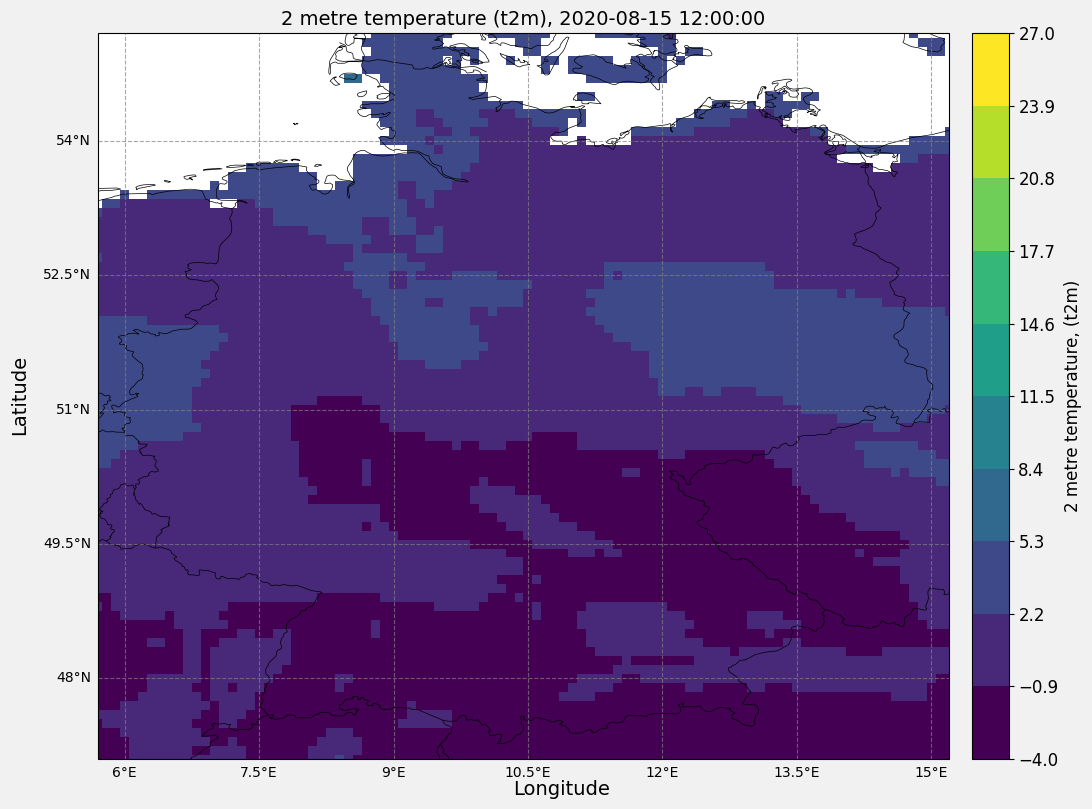

In [18]:
if __name__ == "__main__":
    main_plt_plot(year=2020, month=8, day=15, hour_of_day=12)